# Baseline_CNN_KWS.ipynb

In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
from torch.utils.data import DataLoader, random_split
import torchaudio.transforms as T
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

print("PyTorch:", torch.__version__)
print("Torchaudio:", torchaudio.__version__)
print("MPS Available:", torch.backends.mps.is_available())  # for M1 GPU

PyTorch: 2.8.0+cu126
Torchaudio: 2.8.0+cu126
MPS Available: False


In [2]:
%cd /content

/content


In [3]:

!git clone https://github.com/jimsonjames0/CS-576-Final-Project.git



Cloning into 'CS-576-Final-Project'...
remote: Enumerating objects: 64392, done.
remote: Counting objects: 100% (19/19), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 64392 (delta 5), reused 11 (delta 2), pack-reused 64373 (from 2)
Receiving objects: 100% (64392/64392), 1.36 GiB | 15.73 MiB/s, done.
Resolving deltas: 100% (149/149), done.


In [4]:
%cd CS-576-Final-Project
!git checkout mudit

/content/CS-576-Final-Project
Branch 'mudit' set up to track remote branch 'mudit' from 'origin'.
Switched to a new branch 'mudit'


In [5]:
# --- Setup and Dependencies ---
!pip install torch torchvision torchaudio tqdm soundfile matplotlib numpy

from google.colab import drive
import os

drive.mount('/content/drive')

DATA_DIR = os.path.join(os.getcwd(), "data")
os.makedirs(DATA_DIR, exist_ok=True)

from torchaudio.datasets import SPEECHCOMMANDS
dataset = SPEECHCOMMANDS(root=DATA_DIR, download=True)
print(f"  Dataset ready at: {DATA_DIR}")

import torch
print("CUDA Available:", torch.cuda.is_available())

Mounted at /content/drive


100%|██████████| 2.26G/2.26G [01:43<00:00, 23.4MB/s]


  Dataset ready at: /content/CS-576-Final-Project/data
CUDA Available: True


In [6]:
!ls -R data | head -n 30

data:
SpeechCommands
speech_commands_v0.02.tar.gz

data/SpeechCommands:
speech_commands_v0.02

data/SpeechCommands/speech_commands_v0.02:
_background_noise_
backward
bed
bird
cat
dog
down
eight
five
follow
forward
four
go
happy
house
learn
left
LICENSE
marvin
nine
no
off


In [7]:
# --- IMPORTS AND CONFIGURATION ---
import os
import torch
import torchaudio
import torchaudio.transforms as T

#   Path to dataset
DATA_DIR = "data/SpeechCommands/speech_commands_v0.02"

#   Small subset for faster training
CLASSES = ["yes", "no", "go", "stop", "down", "up"]

#   MFCC parameters
SAMPLE_RATE = 16000
N_MFCC = 40

mfcc_transform = T.MFCC(
    sample_rate=SAMPLE_RATE,
    n_mfcc=N_MFCC,
    melkwargs={
        "n_fft": 400,
        "hop_length": 160,
        "n_mels": 40,
        "center": False
    }
)

print("  MFCC extractor initialized")
print("Sample rate:", SAMPLE_RATE, "| n_mfcc:", N_MFCC)

  MFCC extractor initialized
Sample rate: 16000 | n_mfcc: 40


In [8]:
# --- CUSTOM DATASET WRAPPER ---
from torchaudio.datasets import SPEECHCOMMANDS

class SubsetSC(SPEECHCOMMANDS):
    def __init__(self, subset, classes):
        super().__init__(root="data", download=False)
        self.subset = subset
        self.classes = classes
        self._walker = self._load_list(subset)

    def _load_list(self, subset):
        base = os.path.join(self._path)
        val_list = os.path.join(base, "validation_list.txt")
        test_list = os.path.join(base, "testing_list.txt")

        def read_list(path):
            with open(path, "r") as f:
                return set(line.strip() for line in f)

        val_files = read_list(val_list)
        test_files = read_list(test_list)

        if subset == "validation":
            return [os.path.join(base, f) for f in val_files if f.split("/")[0] in self.classes]
        elif subset == "testing":
            return [os.path.join(base, f) for f in test_files if f.split("/")[0] in self.classes]
        else:
            all_files = []
            for label in self.classes:
                folder = os.path.join(base, label)
                if os.path.isdir(folder):
                    for file in os.listdir(folder):
                        path = os.path.join(label, file)
                        if path not in val_files and path not in test_files:
                            all_files.append(os.path.join(base, path))
            return all_files

    def __getitem__(self, n):
        path = self._walker[n]
        waveform, sr = torchaudio.load(path)
        label = path.split("/")[-2]
        label_idx = self.classes.index(label)
        mfcc = mfcc_transform(waveform).squeeze(0)
        #   Normalize the MFCCs
        mfcc = (mfcc - mfcc.mean()) / (mfcc.std() + 1e-6)
        return mfcc, label_idx

In [9]:
# --- BUILD DATASETS ---
train_set = SubsetSC("training", CLASSES)
val_set   = SubsetSC("validation", CLASSES)
test_set  = SubsetSC("testing", CLASSES)

print("Train samples:", len(train_set))
print("Validation samples:", len(val_set))
print("Test samples:", len(test_set))

Train samples: 18657
Validation samples: 2252
Test samples: 2468


In [10]:
# --- BATCHING HELPERS ---
import torch.nn.functional as F
from torch.utils.data import DataLoader

def pad_sequence(batch):
    tensors, targets = zip(*batch)
    max_len = max(t.shape[1] for t in tensors)
    padded = [F.pad(t, (0, max_len - t.shape[1])) for t in tensors]
    padded = torch.stack(padded)
    targets = torch.tensor(targets)
    return padded, targets

# --- CREATE DATALOADERS ---
BATCH_SIZE = 64

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, collate_fn=pad_sequence)
val_loader   = DataLoader(val_set, batch_size=BATCH_SIZE, collate_fn=pad_sequence)
test_loader  = DataLoader(test_set, batch_size=BATCH_SIZE, collate_fn=pad_sequence)

print(f"Train batches: {len(train_loader)} | Val batches: {len(val_loader)} | Test batches: {len(test_loader)}")

Train batches: 292 | Val batches: 36 | Test batches: 39


In [11]:
import torch.nn as nn

class CNN_KWS(nn.Module):
    def __init__(self, num_classes=len(CLASSES)):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Lazy layer automatically infers input size
        self.classifier = nn.Sequential(
            nn.LazyLinear(64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # [batch, 1, 40, time]
        x = self.features(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

# Instantiate model and show structure
device = "cuda" if torch.cuda.is_available() else "cpu"
model = CNN_KWS().to(device)
print(model)

CNN_KWS(
  (features): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): LazyLinear(in_features=0, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
)


In [12]:
import torch.optim as optim
from tqdm import tqdm

# --- TRAINING SETUP ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)
#   Add learning rate scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
EPOCHS = 30  # you can increase later (e.g., 20–30 for better accuracy)

# --- TRAIN & EVAL FUNCTIONS ---
def train_epoch(loader):
    model.train()
    total_loss, correct = 0, 0
    for x, y in tqdm(loader, desc="Training", leave=False):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)


def evaluate(loader):
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in tqdm(loader, desc="Validating", leave=False):
            x, y = x.to(device), y.to(device)
            out = model(x)
            total_loss += criterion(out, y).item()
            correct += (out.argmax(1) == y).sum().item()
    return total_loss / len(loader), correct / len(loader.dataset)

In [13]:
train_acc, val_acc = [], []
train_loss, val_loss = [], []

for epoch in range(EPOCHS):
    tr_loss, tr_acc = train_epoch(train_loader)
    v_loss, v_acc = evaluate(val_loader)
    scheduler.step()

    train_acc.append(tr_acc)
    val_acc.append(v_acc)
    train_loss.append(tr_loss)
    val_loss.append(v_loss)

    print(f"Epoch {epoch+1}/{EPOCHS}: "
          f"Train Loss={tr_loss:.3f}, Train Acc={tr_acc:.3f} | "
          f"Val Loss={v_loss:.3f}, Val Acc={v_acc:.3f}")

Training:   0%|          | 0/292 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/aud

Epoch 1/30: Train Loss=1.185, Train Acc=0.547 | Val Loss=0.835, Val Acc=0.691


Epoch 2/30: Train Loss=0.759, Train Acc=0.719 | Val Loss=0.681, Val Acc=0.749


Epoch 3/30: Train Loss=0.596, Train Acc=0.784 | Val Loss=0.607, Val Acc=0.790


Epoch 4/30: Train Loss=0.501, Train Acc=0.818 | Val Loss=0.534, Val Acc=0.815


Epoch 5/30: Train Loss=0.423, Train Acc=0.849 | Val Loss=0.488, Val Acc=0.834


Epoch 6/30: Train Loss=0.360, Train Acc=0.871 | Val Loss=0.450, Val Acc=0.839


Epoch 7/30: Train Loss=0.303, Train Acc=0.892 | Val Loss=0.460, Val Acc=0.851


Epoch 8/30: Train Loss=0.264, Train Acc=0.908 | Val Loss=0.427, Val Acc=0.852


Epoch 9/30: Train Loss=0.223, Train Acc=0.923 | Val Loss=0.557, Val Acc=0.824


Epoch 10/30: Train Loss=0.191, Train Acc=0.934 | Val Loss=0.437, Val Acc=0.857


Epoch 11/30: Train Loss=0.139, Train Acc=0.956 | Val Loss=0.414, Val Acc=0.871


Epoch 12/30: Train Loss=0.122, Train Acc=0.962 | Val Loss=0.424, Val Acc=0.872


Epoch 13/30: Train Loss=0.108, Train Acc=0.967 | Val Loss=0.461, Val Acc=0.863


Epoch 14/30: Train Loss=0.094, Train Acc=0.972 | Val Loss=0.480, Val Acc=0.862


Epoch 15/30: Train Loss=0.086, Train Acc=0.973 | Val Loss=0.462, Val Acc=0.868


Epoch 16/30: Train Loss=0.071, Train Acc=0.979 | Val Loss=0.496, Val Acc=0.869


Epoch 17/30: Train Loss=0.064, Train Acc=0.982 | Val Loss=0.535, Val Acc=0.863


Epoch 18/30: Train Loss=0.053, Train Acc=0.987 | Val Loss=0.524, Val Acc=0.865


Epoch 19/30: Train Loss=0.049, Train Acc=0.987 | Val Loss=0.553, Val Acc=0.867


Epoch 20/30: Train Loss=0.039, Train Acc=0.991 | Val Loss=0.559, Val Acc=0.871


Epoch 21/30: Train Loss=0.025, Train Acc=0.996 | Val Loss=0.581, Val Acc=0.869


Epoch 22/30: Train Loss=0.022, Train Acc=0.996 | Val Loss=0.585, Val Acc=0.864


Epoch 23/30: Train Loss=0.020, Train Acc=0.997 | Val Loss=0.601, Val Acc=0.865


Epoch 24/30: Train Loss=0.018, Train Acc=0.998 | Val Loss=0.602, Val Acc=0.875


Epoch 25/30: Train Loss=0.015, Train Acc=0.998 | Val Loss=0.627, Val Acc=0.873


Epoch 26/30: Train Loss=0.014, Train Acc=0.999 | Val Loss=0.681, Val Acc=0.864


Epoch 27/30: Train Loss=0.013, Train Acc=0.999 | Val Loss=0.688, Val Acc=0.860


Epoch 28/30: Train Loss=0.010, Train Acc=0.999 | Val Loss=0.694, Val Acc=0.865


Epoch 29/30: Train Loss=0.010, Train Acc=0.999 | Val Loss=0.698, Val Acc=0.873


Epoch 30/30: Train Loss=0.008, Train Acc=1.000 | Val Loss=0.717, Val Acc=0.868


In [14]:
test_loss, test_acc = evaluate(test_loader)
print(f"\n Test Loss = {test_loss:.3f}")
print(f" Test Accuracy = {test_acc*100:.2f}%")


 Test Loss = 0.720
 Test Accuracy = 85.90%


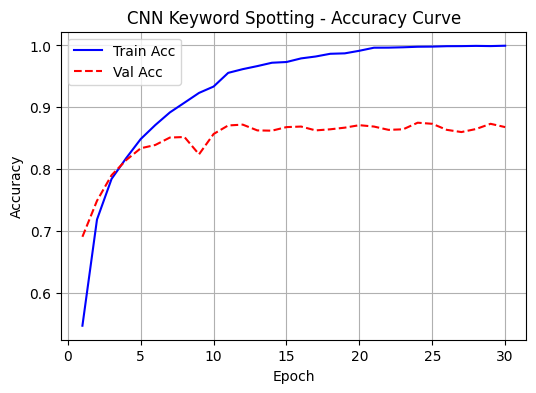

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
plt.plot(range(1, len(train_acc)+1), train_acc, 'b-', label='Train Acc')
plt.plot(range(1, len(val_acc)+1), val_acc, 'r--', label='Val Acc')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("CNN Keyword Spotting - Accuracy Curve")
plt.legend()
plt.grid(True)
plt.show()

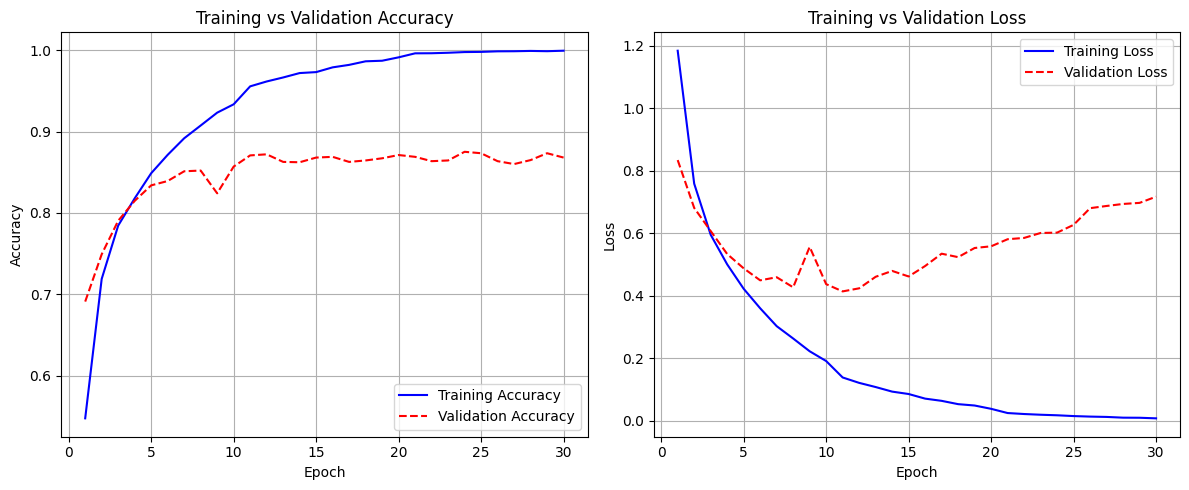

In [16]:
plt.figure(figsize=(12,5))

# Accuracy curve
plt.subplot(1,2,1)
plt.plot(range(1, len(train_acc)+1), train_acc, 'b-', label='Training Accuracy')
plt.plot(range(1, len(val_acc)+1), val_acc, 'r--', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss curve
plt.subplot(1,2,2)
plt.plot(range(1, len(train_loss)+1), train_loss, 'b-', label='Training Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, 'r--', label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [17]:
SAVE_PATH = "/content/drive/MyDrive/baseline_cnn_kws_vfinal.pt"
torch.save(model.state_dict(), SAVE_PATH)
print(f"✅ Final model saved to: {SAVE_PATH}")

✅ Final model saved to: /content/drive/MyDrive/baseline_cnn_kws_vfinal.pt


In [18]:
!mv /content/drive/MyDrive/baseline_cnn_kws_vfinal.pt /content/CS-576-Final-Project/baseline_cnn/

In [19]:
%cd /content/CS-576-Final-Project

/content/CS-576-Final-Project


In [20]:
! git status

On branch mudit
Your branch is up to date with 'origin/mudit'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)
	baseline_cnn/baseline_cnn_kws_vfinal.pt

nothing added to commit but untracked files present (use "git add" to track)
